# RNN Language Model

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [11]:
# P(x| w1, w2, .., wk)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
## Data from https://www.kaggle.com/datasets/auhide/bulgarian-poems/data
## Preprocessed data can be found in my github

In [14]:
with open("chitanka-corpus-prepared.txt", "r", encoding="utf8") as file:
    corpus = file.read()

In [15]:
print(corpus[:2000])

Христо Смирненски
Поема за руското дете
Далеч сред степите безбрежни
в порутен дом лежи дете;
навън виелицата снежна
безкраен бял саван плете.
А редом с болното детенце
простенва ссухрена жена
и взира се с печален поглед
през ледената тъмнина.
— Спи, късно е — му тя нашепва, —
навън се спуска черен мрак.
— Ах, винаги е късно зиме —
отвръща то и стене пак.
А тя му приказки разправя,
поглаждайки го със ръка,
за вещицата баба Яга
с дворец от кокоши крака,
за феята с коси зелени —
далеч там в мътните блата,
как с жабите ведно живее
и чудни песни пее тя…
И слуша бледото момиче
с разтворени от страх очи,
а вънка вихъра разбунен
напява гневно и бучи.
И сякаш някой черен призрак
се носи шеметно в нощта
и удря с вледенени пръсти
по заснежената врата.
А майката се моли тихо,
иконите зове без глас —
стои Исус там скръбнобледен,
с венец от злато и елмаз.
И шепне тя: „Исусе, чуй ме!
Детенцето ми ти спаси!
На таз земя сме всички братя,
а гладна смърт над нас виси.
Спаси ти мойта Василиса,
от глад сп

In [16]:
SPLIT_STRING = '@\n'
MAX_LEN = 10000
SYMBOL_MIN_COUNT = 100
AUTHOR_MIN_COUNT = 20

start_char = '{'
end_char = '}'
unk_char = '@'
pad_char = '|'
unk_author = '(неизвестен автор)'

In [17]:
def getAlphabetAuthors(corpus):
    symbol2count={}
    author2count={}
    for athor_poem in corpus:
        if len(athor_poem) == 0:
            continue

        author_pos = athor_poem.find('\n')
        author = athor_poem[:author_pos]
        if author in author2count:
            author2count[author] += 1
        else:
            author2count[author] = 1
        poem = athor_poem[author_pos+1:]

        for symbol in poem:
            if symbol in symbol2count:
                symbol2count[symbol] += 1
            else:
                symbol2count[symbol] = 1

    return symbol2count, author2count

def prepareData(corpus, start_char=start_char, end_char=end_char, unk_char=unk_char, pad_char=pad_char):
    poems = corpus.split(SPLIT_STRING)
    symbol2count, author2count = getAlphabetAuthors(poems)

    assert  start_char not in symbol2count and \
            end_char not in symbol2count and \
            unk_char not in symbol2count and \
            pad_char not in symbol2count

    charset = [start_char, end_char, unk_char, pad_char] +\
        [char for char in sorted(symbol2count) if symbol2count[char] > SYMBOL_MIN_COUNT]
    char2id = { char : id for id , char in enumerate(charset)}

    authset = [author for author in sorted(author2count) if author2count[author] > AUTHOR_MIN_COUNT]
    auth2id = { author : id for id, author in enumerate(authset)}

    auth_poem = []
    for i, s in enumerate(poems):
        if len(s) == 0:
            continue
        author_pos=s.find('\n')
        aut = s[:author_pos]
        poem = s[author_pos+1:]
        auth_poem.append( (aut, [start_char] + [ poem[i] for i in range(min(len(poem),MAX_LEN)) ] + [end_char]) )

    id2char  = {v: k for k, v in char2id.items()}
    id2auth = {v: k for k, v in auth2id.items()}

    train, val_test = train_test_split(auth_poem, test_size=0.2)
    test, val = train_test_split(val_test, test_size=0.5)

    return train, val, test, char2id, auth2id, id2char, id2auth

In [18]:
train, val, test, char2id, auth2id, id2char, id2auth =\
    prepareData(corpus)

In [19]:
start_char_id = char2id[start_char]
end_char_id = char2id[end_char]
unk_char_id = char2id[unk_char]
pad_char_id = char2id[pad_char]
unk_author_id = auth2id[unk_author]

In [20]:
print(train[0])

('Александър Радонов', ['{', 'Н', 'а', ' ', 'п', 'р', 'а', 'г', 'а', '\n', 'Н', 'а', ' ', 'в', 'е', 'з', 'н', 'а', 'т', 'а', ' ', 'н', 'а', ' ', 'ж', 'и', 'в', 'о', 'т', 'а', ' ', 'и', ' ', 'с', 'м', 'ъ', 'р', 'т', 'т', 'а', ' ', 'с', 'и', ' ', 'т', 'и', ',', '\n', 'н', 'о', ' ', 'н', 'е', ' ', 'з', 'н', 'а', 'е', 'ш', ' ', 'н', 'а', ' ', 'к', 'о', 'я', ' ', 'с', 'т', 'р', 'а', 'н', 'а', ' ', 'С', 'ъ', 'д', 'б', 'а', 'т', 'а', '\n', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', '\xa0', 'щ', 'е', ' ', 'я', ' ', 'н', 'а', 'к', 'л', 'о', 'н', 'и', '.', '\n', 'И', 'м', 'а', 'ш', ' ', 'к', 'а', 'к', 'в', 'о', ' ', 'д', 'а', ' ', 'с', 'в', 'ъ', 'р', 'ш', 'и', 'ш', ' ', 'о', 'щ', 'е', ' ', 'н', 'а', ' ', 'т', 'о', 'з', 'и', ' ', 'с', 'в', 'я', 'т', ',', '\n', 'к', 'ъ', 'д', 'е', 'т', 'о', ' ', 

In [21]:
def tokenizeText(text, char2id=char2id, unk_token_id=unk_char_id):
    result = []

    for char in text:
        result.append(char2id.get(char, unk_token_id))

    return result

In [22]:
def tokenizeAuthorAndText(auth_text, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id):
    authors = []
    poems = []

    for (author, poem) in auth_text:
        authors.append(auth2id.get(author, unk_char_id))
        poems.append(tokenizeText(poem, char2id=char2id, unk_token_id=unk_token_id))

    return authors, poems


In [23]:
def decodeTexts(tokens, id2char=id2char, unk_char_id=unk_char_id):
    result = []

    for token in tokens:
        result.append(id2char.get(token, unk_char_id))

    return ''.join(result[1:-1])

In [24]:
len(char2id)

116

In [25]:
len(auth2id)

125

In [26]:
auth2id

{'(неизвестен автор)': 0,
 'Александър Блок': 1,
 'Александър Радонов': 2,
 'Ана Ахматова': 3,
 'Ангел Попов': 4,
 'Ангелина Жекова': 5,
 'Арсений Тарковски': 6,
 'Артюр Рембо': 7,
 'Асен Босев': 8,
 'Асен Разцветников': 9,
 'Атанас Далчев': 10,
 'Бертолт Брехт': 11,
 'Борис Пастернак': 12,
 'Боян Бойчев': 13,
 'Валери Видас': 14,
 'Валери Иванов': 15,
 'Веса Паспалеева': 16,
 'Веселин Ханчев': 17,
 'Виктор Юго': 18,
 'Владислав Ходасевич': 19,
 'Габриела Цанева': 20,
 'Галина Златина': 21,
 'Гео Милев': 22,
 'Георги Струмски': 23,
 'Георги Щерев': 24,
 'Гюнтер Кунерт': 25,
 'Дамян Дамянов': 26,
 'Деница Минчева': 27,
 'Джани Родари': 28,
 'Джордж Байрон': 29,
 'Дилън Томас': 30,
 'Димитър Бояджиев': 31,
 'Димитър Донев': 32,
 'Димчо Дебелянов': 33,
 'Дора Габе': 34,
 'Евтим Евтимов': 35,
 'Едгар Алън По': 36,
 'Езра Паунд': 37,
 'Екатерина Ненчева': 38,
 'Елин Пелин': 39,
 'Елисавета Багряна': 40,
 'Емили Дикинсън': 41,
 'Живко Лазаров': 42,
 'Змей Горянин': 43,
 'Иван Бунин': 44,
 'И

In [27]:
VOCAB_SIZE = len(char2id)
AUTH_SIZE = len(auth2id)
VOCAB_SIZE, AUTH_SIZE

(116, 125)

In [28]:
train_athor, train_tokenized = tokenizeAuthorAndText(train, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id)
val_athor, val_tokenized = tokenizeAuthorAndText(val, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id)
test_athor, test_tokenized = tokenizeAuthorAndText(test, char2id=char2id, auth2id=auth2id, unk_token_id=unk_char_id, unk_author_id=unk_author_id)

In [29]:
print(train_tokenized[0])

[0, 64, 80, 5, 95, 96, 80, 83, 80, 4, 64, 80, 5, 82, 85, 87, 93, 80, 98, 80, 5, 93, 80, 5, 86, 88, 82, 94, 98, 80, 5, 88, 5, 97, 92, 106, 96, 98, 98, 80, 5, 97, 88, 5, 98, 88, 10, 4, 93, 94, 5, 93, 85, 5, 87, 93, 80, 85, 104, 5, 93, 80, 5, 90, 94, 109, 5, 97, 98, 96, 80, 93, 80, 5, 68, 106, 84, 81, 80, 98, 80, 4, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 105, 85, 5, 109, 5, 93, 80, 90, 91, 94, 93, 88, 12, 4, 59, 92, 80, 104, 5, 90, 80, 90, 82, 94, 5, 84, 80, 5, 97, 82, 106, 96, 104, 88, 104, 5, 94, 105, 85, 5, 93, 80, 5, 98, 94, 87, 88, 5, 97, 82, 109, 98, 10, 4, 90, 106, 84, 85, 98, 94, 5, 86, 88, 82, 94, 98, 106, 98, 5, 98, 88, 5, 85, 5, 83, 80, 84, 85, 93, 10, 5, 95, 106, 91, 85, 93, 5, 51, 84, 12, 4, 65, 98, 5, 84, 82, 80, 84, 85, 97, 85, 98, 5, 83, 94, 84, 88, 93, 88, 5, 98, 106, 96, 97, 88, 104, 5, 105, 80, 97, 98, 88, 85, 5, 88, 5, 91, 108, 81, 94, 82, 12, 4, 61, 80, 98, 94, 5, 69, 80, 93, 98, 

In [30]:
print(decodeTexts(train_tokenized[0], id2char))

На прага
На везната на живота и смъртта си ти,
но не знаеш на коя страна Съдбата
                                ще я наклони.
Имаш какво да свършиш още на този свят,
където животът ти е гаден, пълен Ад.
От двадесет години търсиш щастие и любов.
Като Тантал ги стигаш, но търсиш
                                живота нов.
Адските мъки в живота не можаха да те
                                уплашат,
смъртта на близки и ракът не успяха да те
                                откажат.
И когато вече намери щастието, любовта,
животът с теб се гадно и подло подигра…
На прага на смъртта си вече ти,
Съдбата натам везната наклони…



## Data generator

In [ ]:
def dataGenerator(poem, author, batch_size=32, shuffle_data=True, pad_token_id=pad_char_id):

    if shuffle_data:
        poem, author = shuffle(poem, author)

    n_batches = int(np.ceil(len(author) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(author))

        X_poem = poem[batch * batch_size:end]
        X_author = author[batch * batch_size:end]

        max_len = np.max([len(x) for x in X_poem])
        for sample in range(len(X_poem)):
            x = X_poem[sample]
            pad = [pad_char_id] * (max_len - len(x))
            X_poem[sample] = pad + x

        X_poem = torch.from_numpy(np.array(X_poem)).long()
        X_author = torch.from_numpy(np.array(X_author)).long()

        yield X_poem, X_author

In [ ]:
len(train_tokenized)

11200

In [ ]:
train_gen   = lambda : dataGenerator(train_tokenized, train_athor, batch_size=32)
val_gen     = lambda : dataGenerator(val_tokenized, val_athor, batch_size=32, shuffle_data=False)
test_gen    = lambda : dataGenerator(test_tokenized, test_athor, batch_size=32, shuffle_data=False)

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss = 0
    steps = 0

    for X_poem, X_author in data_loader():
        X_poem, X_author = X_poem.to(device), X_author.to(device)
        y_pred, (h_out, c_out) = model(X_poem[:, :-1], X_author)

        # X_poem[:, 1:].shape: [n_samples, max_seq_len - 1]
        # y_pred.shape: [n_samples, max_seq_len - 1, vocab_size]
        # but PyTorch expects [n_samples, vocab_size, max_seq_len - 1]
        loss = loss_fn(y_pred.transpose(2, 1), X_poem[:, 1:])
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        steps += 1

    return train_loss / steps


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss = 0
    steps = 0

    with torch.inference_mode():
        for X_poem, X_author in data_loader():

            X_poem, X_author = X_poem.to(device), X_author.to(device)

            y_pred, (h_out, c_out) = model(X_poem[:, :-1], X_author)
            # X_poem[:, 1:].shape: [n_samples, max_seq_len - 1]
            # y_pred.shape: [n_samples, max_seq_len - 1, vocab_size]
            # but PyTorch expects [n_samples, vocab_size, max_seq_len - 1]
            loss = loss_fn(y_pred.transpose(2, 1), X_poem[:, 1:])

            test_loss += loss.item()
            steps += 1

    return test_loss / steps

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "test_loss": [],
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]


    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


## RNN

In [6]:
class RNN(nn.Module):
    def __init__(self, n_vocab, n_author, embed_dim, hidden_size, n_layers, dropout=0):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.n_author = n_author
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.out_dim = n_vocab

        self.embed = nn.Embedding(self.V, self.embed_dim)
        self.embed_athor = nn.Embedding(self.n_author, self.n_layers * self.hidden_size)

        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, self.out_dim)


    def forward(self, x, author):
        # x.shape [n_samples, max_seq_len]

        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        # h0.shape = c0.shape: [n_layers, n_samples, hidden_size]
        x = self.embed(x.to(torch.int64))
        author_embed = self.embed_athor(author.to(torch.int64)).view(self.n_layers, x.size(0), self.hidden_size).to(device)
        # author.shape = c0.shape: [n_layers, n_samples, hidden_size]
        # x.shape [n_samples, max_seq_len, embed_dim]
        x, (h_out, c_out) = self.rnn(x, (h0, author_embed))
        # x.shape [n_samples, max_seq_len, hidden_size]

        x = self.fc(x)
        # x.shape [n_samples, max_seq_len, vocab_size]

        return x, (h_out, c_out)

In [ ]:
rnn_model = RNN(n_vocab=VOCAB_SIZE, n_author=len(auth2id), embed_dim=VOCAB_SIZE, hidden_size=384, n_layers=3, dropout=0.5).to(device)

print(rnn_model)

loss = nn.CrossEntropyLoss(ignore_index=pad_char_id)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=2e-3)

RNN(
  (embed): Embedding(116, 116)
  (embed_athor): Embedding(125, 1152)
  (rnn): LSTM(116, 384, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=384, out_features=116, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6168 | test_loss: 2.1109 | time: 390.9438
Epoch: 2 | train_loss: 2.0277 | test_loss: 1.8832 | time: 397.5020
Epoch: 3 | train_loss: 1.8839 | test_loss: 1.7844 | time: 391.5833
Epoch: 4 | train_loss: 1.8091 | test_loss: 1.7274 | time: 390.6791
Epoch: 5 | train_loss: 1.7620 | test_loss: 1.6855 | time: 394.8202
Epoch: 6 | train_loss: 1.7274 | test_loss: 1.6631 | time: 389.4230
Epoch: 7 | train_loss: 1.7001 | test_loss: 1.6361 | time: 382.8350
Epoch: 8 | train_loss: 1.6777 | test_loss: 1.6162 | time: 393.4619
Epoch: 9 | train_loss: 1.6579 | test_loss: 1.6012 | time: 392.4073
Epoch: 10 | train_loss: 1.6435 | test_loss: 1.5889 | time: 395.4890


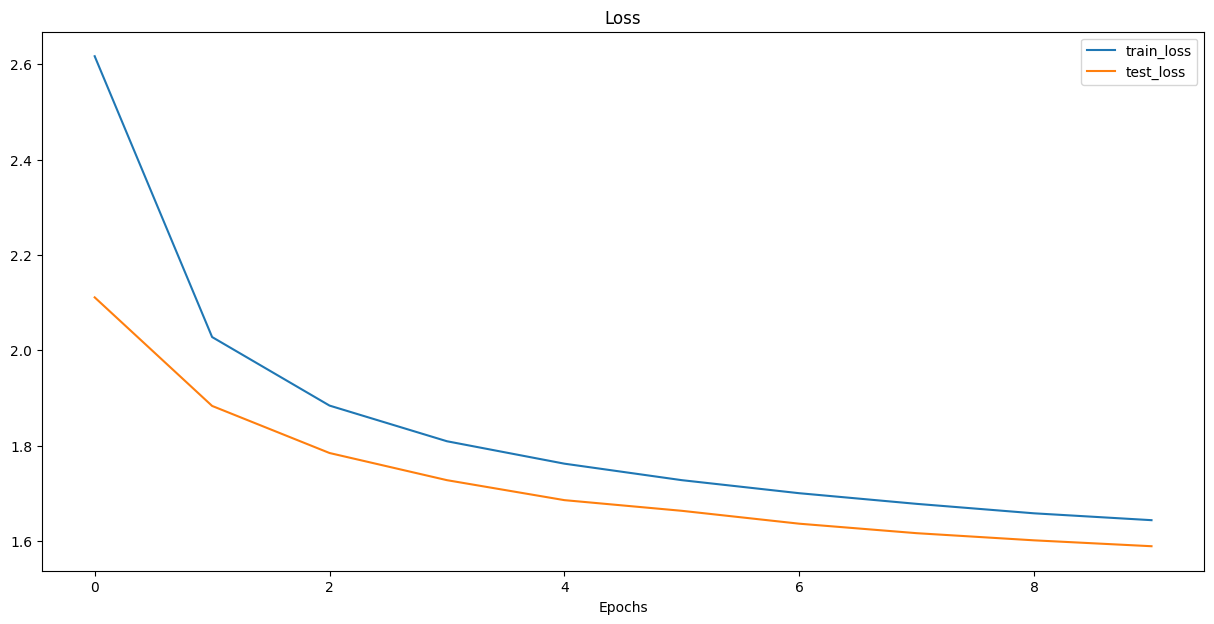

In [ ]:
results = train(model=rnn_model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)

## Testing

In [7]:
def generate(model, promp="", author="(неизвестен автор)", max_len=1000, temperature=0.4):
    result =  promp
    num_symbols = len(char2id)

    tokens = tokenizeText(start_char + promp, char2id=char2id, unk_token_id=unk_char_id)
    output, (h, c) = model(torch.tensor([tokens]).to(device), torch.tensor(auth2id[author]).to(device))
    # output.shape [1, seq_len, vocab_size]
    y = output[:, -1, :][0]
    distribution = torch.nn.functional.softmax(y / temperature, dim=0)
    next_symbol_index = np.random.choice(num_symbols, p=distribution.cpu().detach().numpy())
    next_symbol = id2char[next_symbol_index]
    result += next_symbol

    while len(result) < max_len and next_symbol != end_char:
        symbol = torch.tensor([next_symbol_index], dtype=torch.long, device=device)
        symbol_embed = model.embed(symbol)
        output, (h_new, c_new) = model.rnn(symbol_embed, (h.squeeze(1), c.squeeze(1)))
        output = model.fc(output)
        y = output[0]
        # print(y.shape)
        distribution = torch.nn.functional.softmax(y / temperature, dim=0)

        next_symbol_index = np.random.choice(num_symbols, p=distribution.cpu().detach().numpy())
        next_symbol = id2char[next_symbol_index]
        result += next_symbol
        (h, c) = (h_new, c_new)

    return result


In [8]:
rnn_model = torch.load('rnn_poet.pt', map_location=torch.device(device))

In [ ]:
print(generate(rnn_model))

 Панчест Приказка под моя пет за света
На майката си по небето също погледнало
на твоето съня си на свободата,
която прости си и дълбоко по страх.
Какво е представям се и за да се страдаше с простора.
Да се обичам се като небесата, в нощта писала в света,
пред тебе се върна на небето на неговата си братя,
и в полята се в небето се спуснат и не мисля се възторга,
в тях и съблазни и се смееха в тебе се от небето,
той се спомням на страната с паметниците на тебе.
По стария си ден и се подвигнал с полето да се поставя.
Но всичко съм ти не може да подирна и в пролетно странно.
Те на мойто сърце ми с мен се смееш с това по-добро,
когато в заспалия ми се възмужно с теб не се пристигнат.
Но виждам те пред нощта и да се постига в моите мисли,
не се простори в небесата му в най-сладка и пак простори.
Под мойта страна на бродения съм от полето като подир.
И в душата да открие се под земята на своите дома:
„След това е той се познаваш се в своя страна и със свойта смях
и с тебе се в момичето на св

In [ ]:
auth2id

{'(неизвестен автор)': 0,
 'Александър Блок': 1,
 'Александър Радонов': 2,
 'Ана Ахматова': 3,
 'Ангел Попов': 4,
 'Ангелина Жекова': 5,
 'Арсений Тарковски': 6,
 'Артюр Рембо': 7,
 'Асен Босев': 8,
 'Асен Разцветников': 9,
 'Атанас Далчев': 10,
 'Бертолт Брехт': 11,
 'Борис Пастернак': 12,
 'Боян Бойчев': 13,
 'Валери Видас': 14,
 'Валери Иванов': 15,
 'Веса Паспалеева': 16,
 'Веселин Ханчев': 17,
 'Виктор Юго': 18,
 'Владислав Ходасевич': 19,
 'Габриела Цанева': 20,
 'Галина Златина': 21,
 'Гео Милев': 22,
 'Георги Струмски': 23,
 'Георги Щерев': 24,
 'Гюнтер Кунерт': 25,
 'Дамян Дамянов': 26,
 'Деница Минчева': 27,
 'Джани Родари': 28,
 'Джордж Байрон': 29,
 'Дилън Томас': 30,
 'Димитър Бояджиев': 31,
 'Димитър Донев': 32,
 'Димчо Дебелянов': 33,
 'Дора Габе': 34,
 'Евтим Евтимов': 35,
 'Едгар Алън По': 36,
 'Езра Паунд': 37,
 'Екатерина Ненчева': 38,
 'Елин Пелин': 39,
 'Елисавета Багряна': 40,
 'Емили Дикинсън': 41,
 'Живко Лазаров': 42,
 'Змей Горянин': 43,
 'Иван Бунин': 44,
 'И

In [ ]:
print(generate(rnn_model, promp="", author="Атанас Далчев", max_len=1000, temperature=0.4))

Спомена
Пред нея на душата ми се стигна
в полята на погледа на простора
и от съня на тоя син съзнание,
със свойта страна на странния град.
Но тук всеки сън под земята на сърцето ми
с колене с глас на пристанището си с полята.
Не съм от тебе в страх се заспива на света,
но в странно да се разпитва в страшното си река
и без полето не помисля за тебе мило.
И на него в морето то да се смее.
}


In [ ]:
print(generate(rnn_model, promp="Камък ", author="Атанас Далчев", max_len=1000, temperature=0.4))

Камък съм ли ти се страшната си рано,
със смъртта на този есен на вечерта.
Под небето се виждам се в същите си бяло,
и с от страшни морета и през небето
да ни си от небесата на своя страх.
Под земята с полето се върна в свойта градове
и с тревожно след миг по своя скръб на високото си вода.
Тя се спрем те в страха на двора на небето се славя
с целия ръка на свойте сини и устни и простори.
Самотно по пътя под него под небето на странните пролетни
по простора по-доманно в свободата на всички в съня.
И в страх на своя морето и тъй не е пред нас.
На своя ден не ще се само от страха на небето на смъртта,
под нощта на мойта вода на своя простор и пролетта на свойте горди
на толкова и страхове на другата стена,
в забравата на земята на своята страна се спомнят.
По градини на земята си на този свят на земята.
Те не си ми се обичам и със съдбата на бой се разнежени,
и в тях не съм става се в своя страх и с една сълзи той се страстват.
И видях на полето на всеки сън в гроба на свойто страшно.
На

In [ ]:
print(generate(rnn_model, promp="Камък ", author="Атанас Далчев", max_len=1000, temperature=2))

Камък …
Случва, тоз бял.…
Ето жанX.
Фъна, аг!Н(Сбири янвя
влечи:
И чадчо-дай,@не, оплелт мои,
негенченчто зна
Много тя? —
том Путучдмофък, са
Не тихи,
нопяхме гълъбое,
в жигнала дволци-голо;
И ощната, коя ли,
лопкад… Лулчйнстр{ТЪР
ЗморнЮолюк
Като мрезкюд,
бузи… — Дупа — хуцонек
Крепък, ок0,
че. — Ра-боур:
7/l6
БренхрАДорщoъм;
из цегимкъл Бно/ъА
Те и, Фащ-гас Ад,–Рo@.
}


In [ ]:
print(generate(rnn_model, promp="Камък ", author="Иван Вазов", max_len=1000, temperature=0.4))

Камък на възбудени студени
В борбата не се скрие се в твоите си пера
на въздуха си на красота на страната
на мене се срещнах в полето на града ми.
Пристига в тебе със своя простор и скръб
и с ден по нас се направя се в погледа си с тоя свят.
От тях не е той на теб и полето по свойта сила
на страх и с простора му в тебе слънцето се приличат.
А простора и под него си ти се спокойно,
което усещам от гърдите на моя бряг.
Но той и как се смее сякаш се напразно на гордия си ръка,
с която виждам по странното простора на страховете на свойта село,
до детето и своя странен ден, и от всички в портокалите
и в кораби да се прости са на градовете в съня за мене.
И не спирам се с небето на прозорците на селото,
понеже той в света на своя свят на мене от душата
на простора на своята ми сърце на своя път.
}


In [ ]:
print(generate(rnn_model, promp="Трамвай ", author="Атанас Далчев", max_len=1000, temperature=0.4))

Трамвай в нощта на порой на свободата на времето
С усещам в този всичко пролетта на приказката си.
На своята мирове с покой в своя странно странно,
смело, сред строгото моите сили, по мене само земята на всеки песен,
и в моя простор на простора се от дома на прозореца.
По последните коси и не съм как да можем да започна с гръдта,
разкъсана аз се пристигна с небето на моята стара,
с тебе не се открие, който все още пред тебе се срещнах на земята,
на бой на този свят на своя вечер и сега, и се видяха ли се с портокалността,
но не искам да присмъртвам на горестта, не от страх и се превръща
и се просто си последния дух и се завърна в тъмнината си на света.
Вечер се събираш те с надвискани от градината на страха на небето.
Не се помня да се спирам с представа се с мене на полето на пристанието на славейката на дървото.
На полето във всеки под небето голямо по двама си по пристигнали сърце.
}


In [ ]:
print(generate(rnn_model, promp="Пайторч ", author="Христо Фотев", max_len=10000, temperature=0.3))

Пайторч с любовта на всичко се във страстта на полето
със своя ден се гледа се с този стена
и се направи се и в своя полян на света,
на своя ден се присъщата на мойта страна,
на този син до всеки син от скръб и сърцето.
По свойта сини безсмъртни погледи на вратата,
през своя свят на болката на обич и сърцето,
и се създаде се тревожно с теб и своя свод.
}


In [ ]:
print(generate(rnn_model, promp="Факултет по математика и информатика ", author="Христо Фотев", max_len=10000, temperature=0.3))

Факултет по математика и информатика на детето на вечерния полето на земята
С полето на преди се с полята на света.
Просто си излизам се в моя свят се сърцето си той.
По вечността на своя син и сърцето ми се смее.
От него от скръбта на страховете ми с тебе пред простора,
на скръбта на прозорците на простора си треперят.
Ти не се разбират в света на твоя прозорец на света
на своя простор и под небето на своя свят.
Не се откривам в полето се преди да се познавам.
Но не се спомня в своя страх и сърцето ми пред него ти си страшно.
Не си отиде от миг на тоя ден и сърцето си ти си вие.
С полето с тебе се разкъса се с безкрайно мъжки простори,
и на своя път и с тебе не оставя в тъмнината ми се страхуват.
От всички се отдавна на страх и сърцето си от страх.
И в страшните си крила, които те с тебе са от своя страх.
Не се смеят се за мойта сини и простори, да се разкъсат,
и се случават с камъка на сини полето на съня си с прозореца,
когато се простира в моя син на страх и страшно да се спират.
С

In [ ]:
print(generate(rnn_model, promp="Факултет по математика и информатика ", author="Христо Ботев", max_len=10000, temperature=0.3))

Факултет по математика и информатика на поета на моя страна
По небето на своя ден да се пристигне на простора,
с тебе на своя полет и се случава на скръбта,
но не е с тебе на своя свят на своя пролетта.
Но те не се преди да се справявам на своята страна,
и на простора на славата на всички са по тревите
и по простора на всички под нас от своя смъртта.
На твоя син се от себе си изгряват в косите си на пръстта,
пред тебе не знаеш на морето на обич от всичко за тебе.
И с косите ми се видяха на скръбта от старинния си скръб.
И в страшното си от свойта полето се спомня на полето,
на пътя си в този свят и по сини страшни простори,
които се направи и в тоя свят на света на своя странно.
И той се видях с различни сили, на други води и сърцето.
И сега е там и на всички странни проблизващи кончета,
но с тебе да се прости се в полята на простора на неговата погледа,
и с тебе се смее и никой не се изправи на страната,
и на пътя ми като вече се спомня с развелия гордостта.
Само мойта светлина се сре

In [ ]:
print(generate(rnn_model, promp="Колега ще се видим септември ", author="Гео Милев", max_len=1000, temperature=0.4))

Колега ще се видим септември милост…
Това е на страх и на света и в свойта подходила,
под своята танцуващи обич и слава.
На кораб е сърцето ми в небето не съм от тях.
Под странния си страх да се синее с полето,
в къщите ни от своята изведнъж по комина.
И тъй се спокойно за мен се разбира в небето,
но в тях на полята и нещо ще се направим,
в полята и нежността на своя син в теб ще се разкрие.
И не става се в радост и в полето, дори не съм да се разбира,
те виждам с този вода и без да се спомня, когато
и с теб и невинността на сърцето ми се смее,
и се скрита се с ледността на светлината на моя пролет.
}


In [36]:
print(generate(rnn_model, promp="", author="Гео Милев", max_len=1000, temperature=0.001))

По полето на своя странно сърцето на своя странно сърцето на своя странно сърцето на своя свят на своя свят.
Не се смее се в своя странно сърцето ми с тебе се страхуват.
Не се смее се в своя странно сърцето ми с полето на своя странността.
И в своя странно се смее с тебе се в своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се страхува.
Не се смее се в своя свят и с полето на своя странно сърцето ми се стр

In [41]:
print(generate(rnn_model, promp="Простор", author="Христо Ботев", max_len=1000, temperature=0.1))

Просторите на своя син се страшен сън.
Не се смее се в сърцето ми с тебе с полето,
на своя странно и се страхувам се в своя странността.
И се смее с полето на своя простор на своя странността.
И в своя странно сърцето ми се страшно се страхува.
Не се смее се в своя странно сърцето ми се страхува.
Не се смее се в сърцето на своя простор на своя свят.
На своя страшно се смее и с полето на своя свят.
Не се смее с тебе се в своя странно със своя странно
и в своя полет на своя свят на своя странността.
И в този свят на своя странно сърцето ми се спомня,
но не се смее с тебе се в своя свят и с тебе се спомня.
И в сърцето ми се скрива с тебе се в своя свят.
И в своя свят на своя страх и с тебе се спомнят се с тебе,
но не се спомнят се в своя свят и с полето се смее.
}
